# DNN for Anime Recommendation Engine 

In [1]:
import pickle
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [3]:
DATA_DIR = Path('/content/gdrive/MyDrive/CS247/Final_Project')

## Data preprocessing (skip this section if you have data.pkl and labels.pkl files ready)

In [ ]:
rating_df = pd.read_csv(DATA_DIR/'data.csv', 
                        low_memory=False, 
                        usecols=["user_id", "anime_id", "rating"]
                        )

In [ ]:
anime = pd.read_csv(DATA_DIR/'anime.csv', 
                    low_memory=False
                    )

In [ ]:
#animelist = pd.read_csv(DATA_DIR/'animelist.csv', 
#                        low_memory=True,
#                        usecols=["user_id", "anime_id", "watching_status", "watched_episodes"]
#                        )

In [ ]:
X = rating_df[['user_id', 'anime_id']].values
y = rating_df["rating"].values

In [ ]:
# load data
with open(DATA_DIR/'anime_embedding_map_small.pkl', 'rb') as f:
    anime_embedding_map = pickle.load(f)

with open(DATA_DIR/'genre_embedding_map_small.pkl', 'rb') as f:
    genre_embedding_map = pickle.load(f)

with open(DATA_DIR/'user_embedding_map.pkl', 'rb') as f:
    user_embedding_map = pickle.load(f)

with open(DATA_DIR/'genre_df.pkl', 'rb') as f:
    genre_df = pickle.load(f)

#with open(DATA_DIR/'X.pkl', 'rb') as f:
#    X = pickle.load(f)

#with open(DATA_DIR/'y.pkl', 'rb') as f:
#    y = pickle.load(f)

In [ ]:
X = X[:1050000]
y = y[:1050000]

In [ ]:
len(anime_embedding_map[5]), len(user_embedding_map[259419]), len(genre_embedding_map['Action'][0])

(256, 128, 128)

In [ ]:
genre_map = {}

for index, row in genre_df.iterrows():
    genre_map[int(row['MAL_ID'])] = row['Genres'].split(", ")

In [ ]:
from IPython.display import clear_output
# progress bar to check if the program running
def update_progress(progress):
    bar_length = 50
    if isinstance(progress, int):
        progress = float(progress)
    if not isinstance(progress, float):
        progress = 0
    if progress < 0:
        progress = 0
    if progress >= 1:
        progress = 1
        
    block = int(round(bar_length * progress))

    clear_output(wait = True)
    text = "Progress: [{0}] {1:.1f}%".format( "#" * block + "-" * (bar_length - block), progress * 100)
    print(text)

In [ ]:
X_emb = np.zeros((len(X), 256+128+128+2))
y_emb = np.zeros(len(y))
count = 0
for i in range(len(X)):
    user_id, anime_id = X[i]
    if anime_id not in anime_embedding_map.keys() or user_id not in user_embedding_map.keys():
        continue
    user_embed = user_embedding_map[user_id]
    anime_embed = anime_embedding_map[anime_id]
    genre_embs = [genre_embedding_map[genre][0] for genre in genre_map[anime_id]]
    genre_embs = np.array(genre_embs)
    genre_embed = np.sum(genre_embs, axis=0)  / len(genre_embs)
    score = anime[anime['MAL_ID']==anime_id]['Score'].item()
    episodes = anime[anime['MAL_ID']==anime_id]['Episodes'].item()
    if score == 'Unknown' or episodes == 'Unknown':
        continue
    score = float(score)
    episodes = float(episodes)
    #watching_status = float(animelist[(animelist['user_id']==user_id)&(animelist['anime_id']==anime_id)]['watching_status'].item())
    #watched_episodes = float(animelist[(animelist['user_id']==user_id)&(animelist['anime_id']==anime_id)]['watched_episodes'].item())
    #side_features = np.array([score, episodes, watching_status, watched_episodes])
    side_features = np.array([score, episodes])
    x_emb = np.concatenate((user_embed, anime_embed), axis=None)
    x_emb = np.concatenate((x_emb, genre_embed), axis=None)
    x_emb = np.concatenate((x_emb, side_features), axis=None)
    X_emb[count] = x_emb
    y_emb[count] = y[i]
    count += 1
    update_progress(i/float(len(X)))

print(count)
X_emb = X_emb[:count]
y_emb = y_emb[:count]

In [ ]:
with open(DATA_DIR/'data.pkl', 'wb') as f:
    pickle.dump(X_emb, f)

with open(DATA_DIR/'labels.pkl', 'wb') as f:
    pickle.dump(y_emb, f)

## Load train/test data

In [4]:
with open(DATA_DIR/'data.pkl', 'rb') as f:
    X_emb = pickle.load(f)

with open(DATA_DIR/'labels.pkl', 'rb') as f:
    y_emb = pickle.load(f)

print(len(X_emb), len(y_emb))

1030631 1030631


## DNN training/test

In [5]:
train_size = 1000000

X_train, X_test, y_train, y_test = (
    X_emb[:train_size],
    X_emb[train_size:],
    y_emb[:train_size],
    y_emb[train_size:],
)

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"running on {device}")

running on cuda


In [8]:
batch_size = 128
train_tensor = TensorDataset(torch.FloatTensor(X_train).to(device), torch.FloatTensor(y_train).view(-1,1).to(device))
test_tensor = TensorDataset(torch.FloatTensor(X_test).to(device), torch.FloatTensor(y_test).view(-1,1).to(device))
train_dl = DataLoader(train_tensor, batch_size=batch_size, shuffle=True)
test_dl = DataLoader(test_tensor, batch_size=batch_size)

In [9]:
class DNN(nn.Module):
    def __init__(self):
        super(DNN, self).__init__()
        self.main = nn.Sequential(
            nn.Linear(514, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.main(x)
        return x

    def train_net(self, train_dl, test_dl, epochs=15):
        self.to(device)
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        train_loss_list = []
        test_loss_list = []
        
        for epoch in range(epochs):
            self.train()
            train_loss = 0
            for i, (data,labels) in enumerate(train_dl):
                data, labels = data.to(device), labels.to(device)
                optimizer.zero_grad()
                prediction = self(data)
                loss = torch.sqrt(nn.MSELoss()(prediction, labels)) # RMSE Loss
                loss.backward()
                optimizer.step()
                train_loss += loss
            train_loss /= (i+1) 

            self.eval()
            test_loss = self.test(test_dl)

            print ('Epoch:%d, train loss: %f, test loss: %f'%(epoch+1, train_loss, test_loss))
            train_loss_list.append(train_loss)
            test_loss_list.append(test_loss)

        return train_loss_list, test_loss_list

    def test(self, test_dl):
        self.eval()
        loss = 0
        with torch.no_grad():
            for i, (data,label) in enumerate(test_dl):
                data, label = data.to(device), label.to(device)
                prediction = self(data)
                loss += torch.sqrt(nn.MSELoss()(prediction, label)) # RMSE Loss
        loss /= (i+1)
        return loss

In [10]:
dnn = DNN().to(device)
n_epochs = 30
train_loss_list, test_loss_list = dnn.train_net(train_dl, test_dl, epochs=n_epochs)

Epoch:1, train loss: 0.272476, test loss: 0.270811
Epoch:2, train loss: 0.268704, test loss: 0.267462
Epoch:3, train loss: 0.266556, test loss: 0.264551
Epoch:4, train loss: 0.263926, test loss: 0.263694
Epoch:5, train loss: 0.260834, test loss: 0.261056
Epoch:6, train loss: 0.257486, test loss: 0.257831
Epoch:7, train loss: 0.254002, test loss: 0.252789
Epoch:8, train loss: 0.250869, test loss: 0.249807
Epoch:9, train loss: 0.248221, test loss: 0.247450
Epoch:10, train loss: 0.246070, test loss: 0.246045
Epoch:11, train loss: 0.244451, test loss: 0.246147
Epoch:12, train loss: 0.243117, test loss: 0.243273
Epoch:13, train loss: 0.241807, test loss: 0.242792
Epoch:14, train loss: 0.240663, test loss: 0.243160
Epoch:15, train loss: 0.239908, test loss: 0.243159
Epoch:16, train loss: 0.239101, test loss: 0.240050
Epoch:17, train loss: 0.238434, test loss: 0.240282
Epoch:18, train loss: 0.237816, test loss: 0.240907
Epoch:19, train loss: 0.237150, test loss: 0.239336
Epoch:20, train loss:

In [11]:
train_loss_list = [loss.cpu().detach().numpy() for loss in train_loss_list]
test_loss_list = [loss.cpu().detach().numpy() for loss in test_loss_list]

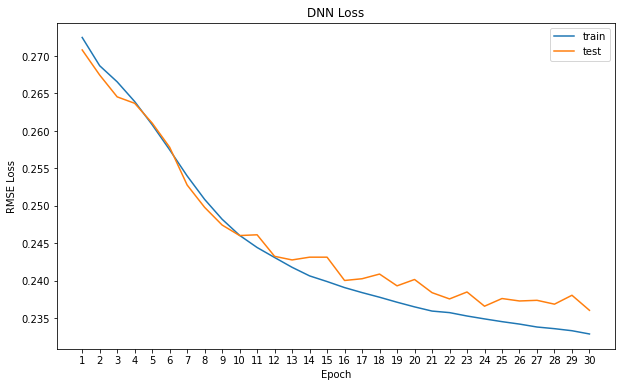

<Figure size 432x288 with 0 Axes>

In [14]:
plt.figure(figsize=(10, 6))
plt.plot([i for i in range(1,n_epochs+1)],train_loss_list,label="train")
plt.plot([i for i in range(1,n_epochs+1)],test_loss_list,label="test")
plt.xticks(range(1,n_epochs+1))
plt.xlabel('Epoch')
plt.ylabel('RMSE Loss')
plt.title('DNN Loss')
plt.legend()
plt.show()
plt.clf()

In [ ]:
dnn.forward(torch.FloatTensor(X_test[300:310]).to(device)), y_test[300:310]

(tensor([[5.5308e-01],
         [4.5496e-01],
         [6.7353e-01],
         [2.0245e-01],
         [4.8976e-01],
         [4.7114e-01],
         [6.2567e-01],
         [6.9839e-01],
         [6.8118e-01],
         [4.8228e-04]], device='cuda:0', grad_fn=<SigmoidBackward0>),
 array([0. , 0.4, 0.7, 0.5, 0.6, 0.6, 0.7, 0.7, 0.7, 0. ]))